In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from eumap.misc import find_files, ttprint, nan_percentile, GoogleSheet
from eumap.raster import read_rasters, save_rasters
import warnings
import multiprocess as mp
import time
from scipy.special import expit, logit
import warnings
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
import joblib
import pickle
from sklearn.metrics import r2_score, mean_squared_error, make_scorer#, root_mean_squared_error
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
# from cubist import Cubist
from sklearn.base import BaseEstimator, TransformerMixin
from pathlib import Path
from benchmark_pipeline import read_features, run_cumusort, parameter_fine_tuning, evaluate_model, calc_ccc, separate_data
### input
folder = 'http://192.168.1.30:8333/ai4sh-landmasked/model_benchmark'
from log_back_transform_rf import TreesRandomForestRegressor

prop_list = ['ocd','oc','bulk_density', 'ph_cacl2','ph_h2o','N','caco3','K','EC','P','CEC','texture1','texture2'] # unitl N everything has lightGBM models
space_list = ['log1p','log1p','normal', 'normal','normal','log1p','log1p','log1p','log1p','log1p','log1p','log1p','log1p'] # 
filt_list = [5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5] #5,5,5,5,

In [3]:
rng = np.random.default_rng(seed=43)
a = rng.integers(0,100, size=5)
print(a)

[50 65 40  4 57]


In [4]:
import shutil
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

n_jobs=90
cv = GroupKFold(n_splits=5) 
rsl = []
prop = 'ocd'
space = 'log1p'
output_folder = f'/home/opengeohub/xuemeng/work_xuemeng/soc/results_new/{prop}'
tgt = f'{prop}_log1p'

# covariates
pathc = f'/home/opengeohub/xuemeng/work_xuemeng/soc/results_new/{prop}/benchmark_selected.covs_{prop}.txt'
covs = read_features(pathc) 

# data
cal = pd.read_csv(f'{output_folder}/benchmark_cal.pnts_{prop}.csv',low_memory=False)
cal = cal.dropna(subset=covs+[tgt],how='any')

for ii in a:#range(len(prop_list)):
    ttprint(f'cross val predict {prop}, in {space} space, random state {ii}')
    for n_trees in np.arange(16,240,8):
        model = RandomForestRegressor(random_state=ii, n_jobs=80, n_estimators=n_trees)
        
        
        y_cv = cross_val_predict(model, cal[covs], cal[tgt], cv=cv, groups=cal['tile_id'], n_jobs=60)
        
        if space == 'log1p':
            # performance metrics
            rsl.append({
                'property': prop,
                'random state': ii,
                'tree number':n_trees,
                'MAE_cv_ori': mean_absolute_error(cal[prop],np.expm1(y_cv)),
                'MAPE_cv_ori': mean_absolute_percentage_error(cal[prop],np.expm1(y_cv)),
                'bias_cv_ori': np.mean(np.expm1(y_cv) - cal[prop]),
                'CCC_cv_ori': calc_ccc(cal[prop],np.expm1(y_cv)),
                'R2_cv_ori': r2_score(cal[prop],np.expm1(y_cv)),
                'MAE_cv_log': mean_absolute_error(cal[tgt],y_cv),
                'MAPE_cv_log': mean_absolute_percentage_error(cal[tgt],y_cv),
                'CCC_cv_log': calc_ccc(cal[tgt],y_cv),
                'R2_cv_log': r2_score(cal[tgt],y_cv),
                'bias_cv_log': np.mean(y_cv-cal[tgt]),
            })
            
        else:
            rsl.append({
                'property': prop,
                'random state': ii,
                'tree number':n_trees,
                'MAE_cv_ori': mean_absolute_error(cal[prop],y_cv),
                'MAPE_cv_ori': mean_absolute_percentage_error(cal[prop],y_cv),
                'CCC_cv_ori': calc_ccc(cal[prop],y_cv),
                'R2_cv_ori': r2_score(cal[prop],y_cv),
                'bias_cv_ori': np.mean(y_cv-cal[prop]),
                'MAE_cv_log': mean_absolute_error(np.log1p(cal[tgt]),np.log1p(y_cv)),
                'MAPE_cv_log': mean_absolute_percentage_error(np.log1p(cal[tgt]),np.log1p(y_cv)),
                'CCC_cv_log': calc_ccc(np.log1p(cal[tgt]),np.log1p(y_cv)),
                'R2_cv_log': r2_score(np.log1p(cal[tgt]),np.log1p(y_cv)),
                'bias_cv_log': np.mean(np.log1p(y_cv) - np.log1p(cal[tgt])),
            })
        
rsl = pd.DataFrame(rsl) 
rsl.to_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/metrics_tree.number.csv',index=False)

[16:04:13] cross val predict ocd, in log1p space, random state 50
[16:05:49] cross val predict ocd, in log1p space, random state 65
[16:07:16] cross val predict ocd, in log1p space, random state 40
[16:08:43] cross val predict ocd, in log1p space, random state 4
[16:10:09] cross val predict ocd, in log1p space, random state 57


In [6]:
rsl = rsl.drop(columns='property')
ave = rsl.groupby('tree number').mean().reset_index()

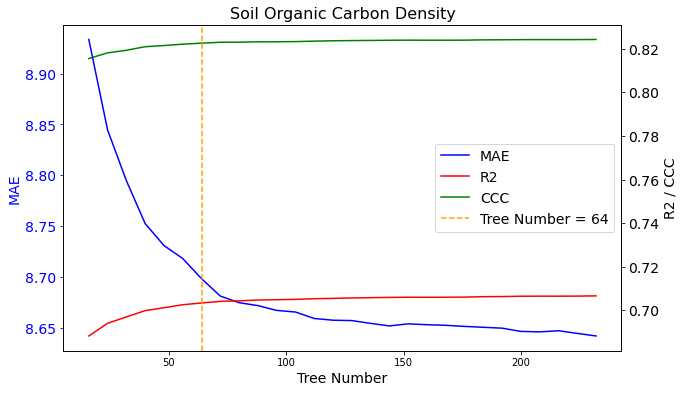

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

# rsl = pd.read_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/metrics_tree.number.csv',low_memory=False)

# prop = 'ocd'
# temp = rsl.loc[rsl['property']==prop]
temp = ave
temp['rank_MAE_cv_ori'] = temp['MAE_cv_ori'].rank(ascending=True) # Rank MAE and MAPE (smaller is better)
# temp['rank_MAPE_cv_ori'] = temp['MAPE_cv_ori'].rank(ascending=True) 
temp['rank_CCC_cv_log'] = temp['CCC_cv_log'].rank(ascending=False) # Rank CCC and R2 (higher is better)
temp['rank_R2_cv_log'] = temp['R2_cv_log'].rank(ascending=False)
temp['combined_rank'] = temp[['rank_MAE_cv_ori', 'rank_R2_cv_log', 'rank_CCC_cv_log']].mean(axis=1) # Combine rankings

# Select the best tree number based on the combined rank
best_tree_index = temp['combined_rank'].idxmin()
best_tree_number = temp.loc[best_tree_index, 'tree number']

fig, ax1 = plt.subplots(figsize=(10, 6))  # Increase the figure size
ax1.plot(temp['tree number'], temp['MAE_cv_ori'], 'b-', label='MAE')
ax1.set_xlabel('Tree Number', fontsize=14)
ax1.set_ylabel('MAE', color='b', fontsize=14)
ax1.tick_params('y', colors='b', labelsize=14)

ax2 = ax1.twinx()
ax2.plot(temp['tree number'], temp['R2_cv_log'], 'r-', label='R2')
ax2.plot(temp['tree number'], temp['CCC_cv_log'], 'g-', label='CCC')
ax2.set_ylabel('R2 / CCC', color='black', fontsize=14)
ax2.tick_params('y', colors='black', labelsize=14)

plt.axvline(x=64, color='orange', linestyle='--', label='Tree Number = 64')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center right' , fontsize=14)

plt.title(f'Soil Organic Carbon Density', fontsize=16) #\nbest tree number: {best_tree_number}

# # Save the figure with high resolution
plt.savefig(f'/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/plot_tree.numbers_{prop}.pdf', dpi=300)
plt.show()

In [8]:
from scipy.signal import find_peaks
tree_numbers = ave['tree number']
mae_values = ave['MAE_cv_ori']

second_derivative = np.diff(mae_values, n=2)
peaks, _ = find_peaks(-second_derivative)  # We use negative to find minima
elbow_point_index = peaks[0] if len(peaks) > 0 else None
elbow_tree_number = tree_numbers.iloc[elbow_point_index] if elbow_point_index is not None else None
elbow_tree_number

24